<a href="https://colab.research.google.com/github/j-a-r-v-i/Analyzing-the-bitcoin-trends/blob/master/topic_modelling_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import datetime

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

import zipfile
from google.colab import files
uploaded = files.upload()

Saving sample_submission_UVKGLZE.csv to sample_submission_UVKGLZE.csv
Saving test.csv to test.csv


In [4]:
import io
df_test= pd.read_csv(io.BytesIO(uploaded['test.csv']))
df_submit = pd.read_csv(io.BytesIO(uploaded['sample_submission_UVKGLZE.csv']))
df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

In [5]:
df_train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [6]:
df_test.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [7]:
df_train.shape

(20972, 9)

In [8]:

print('number of titles:', df_train['TITLE'].nunique())

number of titles: 20972


In [10]:
df_train.isna().sum()

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

# Topic Modelling

In [11]:

#Installing the libraries
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.9MB/s 
     |████████████████████████████████| 552kB 16.6MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=7c8d136a7c3b5bac371e49ef30043a808a02b81e2b1ac43186f32e4804dba1f0
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=70ff8f5af63862a27d8b9992c8f8ab084916ae4af60b4521126cf92c04cd141b
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [12]:

!pip install gensim --upgrade

     |████████████████████████████████| 24.2MB 168kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [13]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2020-08-20 07:08:57--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  12.4MB/s    in 1.2s    

2020-08-20 07:08:58 (12.4 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [16]:
import os

In [22]:
df=df_test

In [24]:

df.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [25]:

os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [26]:
#Topic modeling
# spacy for lemmatization
import spacy;
import en_core_web_sm
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [27]:
#text preprocessing
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('wordnet')

#hide warning
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
df.columns

Index(['ID', 'TITLE', 'ABSTRACT'], dtype='object')

In [29]:

# tokenize each sentence into a list of words, removing punctuations
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['ABSTRACT']))

# Remove Stop and common Words
stopwords = nltk.corpus.stopwords.words('english')
# 'home', 'stay','new','york', 'time',
newStopWords =  ['s','t',  'm', 're','don','ve','2', '3', '1', 
                 'it', 'i', 'us', 'get', 'you', 'let', 'going', 'know', 
                'make', 'take', 'still','got', 'can', 'this', 'all', 'me','go',
                'even', 'here', 'well', 'much', 'many', 'way', 'want', 'every', 'little']
stopwords.extend(newStopWords)

data_words = [[word for word in doc if word not in stopwords] for doc in data_words]

In [31]:
# restrict words to only noun, adjective, verb and adverb
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [32]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

## Finding the optimal number of topics using LdaMallet model

In [33]:
start=24
limit=35
step=2
random = 155

In [34]:
# Write the function to compute coherence values for each model. 
# This could help us choose how many topics should be included into our model.

def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,random_seed=random)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [35]:
# compute coherence values for each model

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

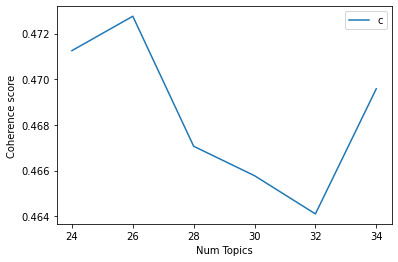

In [36]:
# plot the coherence values when number of topics equals to different numbers
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
# The graph tell us about what number of topics to choose so we will choose 28 as it has maximum coherence score at that point

In [38]:

# plot the coherence values when number of topics equals to different numbers
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

#If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.
#So for further steps I will choose the model with 26 topics itself.

Num Topics = 24  has Coherence Value of 0.4713
Num Topics = 26  has Coherence Value of 0.4728
Num Topics = 28  has Coherence Value of 0.4671
Num Topics = 30  has Coherence Value of 0.4658
Num Topics = 32  has Coherence Value of 0.4641
Num Topics = 34  has Coherence Value of 0.4696


## Finding Key Words for each topic using optimal LdaMallet model¶

In [39]:
#mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus,
                                             num_topics=26, 
                                             id2word=id2word,
                                             random_seed = 155)

In [40]:
model_topics = ldamallet.show_topics(formatted=False)

pprint(sorted(ldamallet.print_topics(num_words=4)))

[(0, '0.040*"control" + 0.024*"environment" + 0.022*"agent" + 0.021*"policy"'),
 (1, '0.053*"system" + 0.033*"application" + 0.020*"tool" + 0.017*"discuss"'),
 (2, '0.024*"code" + 0.023*"present" + 0.019*"language" + 0.019*"introduce"'),
 (3,
  '0.303*"model" + 0.051*"process" + 0.034*"prediction" + 0.021*"parameter"'),
 (4, '0.044*"equation" + 0.043*"system" + 0.029*"flow" + 0.026*"solution"'),
 (5, '0.028*"study" + 0.021*"change" + 0.020*"dynamic" + 0.017*"cell"'),
 (7, '0.043*"network" + 0.032*"system" + 0.029*"power" + 0.020*"node"'),
 (8, '0.050*"group" + 0.036*"theory" + 0.028*"type" + 0.025*"give"'),
 (10, '0.020*"source" + 0.020*"find" + 0.019*"observation" + 0.019*"star"'),
 (11, '0.042*"prove" + 0.031*"function" + 0.027*"give" + 0.022*"condition"'),
 (12, '0.151*"problem" + 0.045*"algorithm" + 0.040*"set" + 0.033*"solution"'),
 (13, '0.122*"method" + 0.091*"propose" + 0.058*"performance" + 0.057*"base"'),
 (15, '0.066*"function" + 0.036*"rate" + 0.031*"local" + 0.029*"method"

In [41]:
pprint(model_topics)

[(22,
  [('result', 0.06024844720496894),
   ('present', 0.05044365572315883),
   ('technique', 0.046805678793256436),
   ('provide', 0.03881987577639751),
   ('analysis', 0.03833185448092281),
   ('work', 0.03318544809228039),
   ('generate', 0.027417923691215616),
   ('base', 0.02715173025732032),
   ('approach', 0.02688553682342502),
   ('apply', 0.025377107364685004)]),
 (21,
  [('distribution', 0.07189827113182075),
   ('measure', 0.04367896180812612),
   ('sample', 0.04302573705526282),
   ('cluster', 0.033445107346601055),
   ('probability', 0.03183381962287157),
   ('distance', 0.025824151896529198),
   ('study', 0.021991900013064496),
   ('result', 0.02016287070504725),
   ('show', 0.01894351783303575),
   ('case', 0.015241910900143709)]),
 (2,
  [('code', 0.024247182708294845),
   ('present', 0.02263070386107519),
   ('language', 0.01925919083687419),
   ('introduce', 0.018751154627748012),
   ('search', 0.018751154627748012),
   ('base', 0.01838167374838352),
   ('tree', 0.0

In [42]:

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)
#More the coherence score more is better keyword


Coherence Score:  0.4727626953670664


## Dominant topic for each document

In [43]:
tm_results = ldamallet[corpus]

In [44]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

In [45]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]

In [46]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26
Term1,control,system,code,model,equation,study,datum,network,group,estimate,source,prove,problem,method,large,function,user,image,number,space,network,distribution,result,field,state,surface
Term2,environment,application,present,process,system,change,feature,system,theory,test,find,function,algorithm,propose,high,rate,information,object,graph,point,learn,measure,present,magnetic,phase,form
Term3,agent,tool,language,prediction,flow,dynamic,real,power,type,parameter,observation,give,set,performance,time,local,social,signal,time,dimension,neural,sample,technique,energy,spin,find
Term4,policy,discuss,search,parameter,solution,cell,data,node,give,variable,star,condition,solution,base,scale,method,study,detection,show,dimensional,deep,cluster,provide,effect,transition,gas
Term5,state,provide,introduce,approach,time,effect,dataset,distribute,define,estimator,high,polynomial,optimal,approach,order,show,community,spatial,size,matrix,task,probability,analysis,mode,order,core


In [47]:
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,Terms per Topic
Topic1,"control, environment, agent, policy, state, strategy, learn, approach, game, robot, decision, system, task, motion, human, action, attack, real, base, make"
Topic2,"system, application, tool, discuss, provide, open, design, describe, area, recent, development, process, software, include, technology, develop, research, source, project, challenge"
Topic3,"code, present, language, search, introduce, base, tree, input, result, simple, program, work, call, provide, natural, show, paper, output, run, implement"
Topic4,"model, process, prediction, parameter, approach, prior, base, predict, inference, latent, uncertainty, develop, framework, probabilistic, modeling, capture, temporal, represent, show, stage"
Topic5,"equation, system, flow, solution, time, wave, dynamic, numerical, condition, nonlinear, particle, boundary, stability, perturbation, initial, dynamical, couple, differential, potential, simulation"
Topic6,"study, change, dynamic, cell, effect, behavior, individual, role, level, pattern, increase, population, mechanism, structure, play, interaction, brain, find, influence, lead"
Topic7,"datum, feature, real, data, dataset, machine, set, classification, selection, world, accuracy, propose, classifier, application, perform, algorithm, class, pattern, domain, method"
Topic8,"network, system, power, node, distribute, communication, energy, device, propose, channel, paper, time, resource, cost, access, multiple, base, increase, information, design"
Topic9,"group, theory, type, give, define, class, structure, show, construct, category, classical, invariant, property, algebra, representation, lie, notion, form, relation, description"
Topic10,"estimate, test, parameter, variable, estimator, statistical, estimation, regression, error, study, procedure, random, statistic, derive, kernel, assumption, illustrate, provide, apply, asymptotic"


In [48]:
# create a dataframe
corpus_topic_df = pd.DataFrame()
# get the Titles from the original dataframe
corpus_topic_df['TITLE'] = df.TITLE
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df.head()

,TITLE,Dominant Topic,Contribution %,Topic Terms
0,Closed-form Marginal Likelihood in Gamma-Poisson Matrix Factorization,10,7.40,"estimate, test, parameter, variable, estimator, statistical, estimation, regression, error, study, procedure, random, statistic, derive, kernel, assumption, illustrate, provide, apply, asymptotic"
1,Laboratory mid-IR spectra of equilibrated and igneous meteorites. Searching for observables of planetesimal debris,26,31.16,"surface, form, find, gas, core, region, formation, velocity, observe, result, disk, density, small, high, planet, low, evolution, rate, period, effect"
2,Case For Static AMSDU Aggregation in WLANs,8,17.02,"network, system, power, node, distribute, communication, energy, device, propose, channel, paper, time, resource, cost, access, multiple, base, increase, information, design"
3,The $Gaia$-ESO Survey: the inner disk intermediate-age open cluster NGC 6802,11,28.80,"source, find, observation, star, high, line, mass, measurement, low, galaxy, large, light, matter, emission, survey, dark, spectral, present, cluster, stellar"
4,Witness-Functions versus Interpretation-Functions for Secrecy in Cryptographic Protocols: What to Choose?,8,14.24,"network, system, power, node, distribute, communication, energy, device, propose, channel, paper, time, resource, cost, access, multiple, base, increase, information, design"


In [ ]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=df["TITLE"]):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num+1), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = sent_topics_df.join(contents)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=df["TITLE"])
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'TITLE']

# Show

In [52]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,TITLE
0,0,10.0,0.0740,"estimate, test, parameter, variable, estimator, statistical, estimation, regression, error, study",Closed-form Marginal Likelihood in Gamma-Poisson Matrix Factorization
1,1,26.0,0.3116,"surface, form, find, gas, core, region, formation, velocity, observe, result",Laboratory mid-IR spectra of equilibrated and igneous meteorites. Searching for observables of planetesimal debris
2,2,8.0,0.1702,"network, system, power, node, distribute, communication, energy, device, propose, channel",Case For Static AMSDU Aggregation in WLANs
3,3,11.0,0.2880,"source, find, observation, star, high, line, mass, measurement, low, galaxy",The $Gaia$-ESO Survey: the inner disk intermediate-age open cluster NGC 6802
4,4,8.0,0.1424,"network, system, power, node, distribute, communication, energy, device, propose, channel",Witness-Functions versus Interpretation-Functions for Secrecy in Cryptographic Protocols: What to Choose?


In [58]:
df_merged= pd.merge(df,df_dominant_topic, on=["TITLE"])

In [59]:
df_merged.head()

,ID,TITLE,ABSTRACT,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,20973,Closed-form Marginal Likelihood in Gamma-Poisson Matrix Factorization,"We present novel understandings of the Gamma-Poisson (GaP) model, a\nprobabilistic matrix factorization model for count data. We show that GaP can\nbe rewritten free of the score/activation matrix. This gives us new insights\nabout the estimation of the topic/dictionary matrix by maximum marginal\nlikelihood estimation. In particular, this explains the robustness of this\nestimator to over-specified values of the factorization rank, especially its\nability to automatically prune irrelevant dictionary columns, as empirically\nobserved in previous work. The marginalization of the activation matrix leads\nin turn to a new Monte Carlo Expectation-Maximization algorithm with favorable\nproperties.\n",0,10.0,0.0740,"estimate, test, parameter, variable, estimator, statistical, estimation, regression, error, study"
1,20974,Laboratory mid-IR spectra of equilibrated and igneous meteorites. Searching for observables of planetesimal debris,"Meteorites contain minerals from Solar System asteroids with different\nproperties (like size, presence of water, core formation). We provide new\nmid-IR transmission spectra of powdered meteorites to obtain templates of how\nmid-IR spectra of asteroidal debris would look like. This is essential for\ninterpreting mid-IR spectra of past and future space observatories, like the\nJames Webb Space Telescope. We show that the transmission spectra of wet and\ndry chondrites, carbonaceous and ordinary chondrites and achondrite and\nchondrite meteorites are distinctly different in a way one can distinguish in\nastronomical mid-IR spectra. The two observables that spectroscopically\nseparate the different meteorites groups (and thus the different types of\nparent bodies) are the pyroxene-olivine feature strength ratio and the peak\nshift of the olivine spectral features due to an increase in the iron\nconcentration of the olivine.\n",1,26.0,0.3116,"surface, form, find, gas, core, region, formation, velocity, observe, result"
2,20975,Case For Static AMSDU Aggregation in WLANs,"Frame aggregation is a mechanism by which multiple frames are combined into a\nsingle transmission unit over the air. Frames aggregated at the AMSDU level use\na common CRC check to enforce integrity. For longer aggregated AMSDU frames,\nthe packet error rate increases significantly for the same bit error rate.\nHence, multiple studies have proposed doing AMSDU aggregation adaptively based\non the error rate. This study evaluates if there is a \emph{practical}\nadvantage in doing adaptive AMSDU aggregation based on the link bit error rate.\nEvaluations on a model show that instead of implementing a complex adaptive\nAMSDU frame aggregation mechanism which impact queuing and other implementation\naspects, it is easier to influence packet error rate with traditional\nmechanisms while keeping the AMSDU aggregation logic simple.\n",2,8.0,0.1702,"network, system, power, node, distribute, communication, energy, device, propose, channel"
3,20976,The $Gaia$-ESO Survey: the inner disk intermediate-age open cluster NGC 6802,"Milky Way open clusters are very diverse in terms of age, chemical\ncomposition, and kinematic properties. Intermediate-age and old open clusters\nare less common, and it is even harder to find them inside the solar\nGalactocentric radius, due to the high mortality rate and strong extinction\ninside this region. NGC 6802 is one of the inner disk open clusters (IOCs)\nobserved by the $Gaia$-ESO survey (GES). This cluster is an important target\nfor calibrating the abundances derived in the survey due to the kinematic and\nchemical homogeneity of the members in open clusters. Using the measurements\nfrom $Gaia$-ESO internal data release 4 (iDR4), we identify 95 main-sequence\ndwarfs as cluster members from the GIRAFFE target list, and eight giants as\ncluster members from the UVES

In [60]:
df_merged.columns

Index(['ID', 'TITLE', 'ABSTRACT', 'Document_No', 'Dominant_Topic',
       'Topic_Perc_Contrib', 'Keywords'],
      dtype='object')

In [61]:
df_merged_test=df_merged.drop(['Dominant_Topic','ABSTRACT','Document_No'],axis=1)

In [63]:
df_merged_test.head(100)

,ID,TITLE,Topic_Perc_Contrib,Keywords
0,20973,Closed-form Marginal Likelihood in Gamma-Poisson Matrix Factorization,0.0740,"estimate, test, parameter, variable, estimator, statistical, estimation, regression, error, study"
1,20974,Laboratory mid-IR spectra of equilibrated and igneous meteorites. Searching for observables of planetesimal debris,0.3116,"surface, form, find, gas, core, region, formation, velocity, observe, result"
2,20975,Case For Static AMSDU Aggregation in WLANs,0.1702,"network, system, power, node, distribute, communication, energy, device, propose, channel"
3,20976,The $Gaia$-ESO Survey: the inner disk intermediate-age open cluster NGC 6802,0.2880,"source, find, observation, star, high, line, mass, measurement, low, galaxy"
4,20977,Witness-Functions versus Interpretation-Functions for Secrecy in Cryptographic Protocols: What to Choose?,0.1424,"network, system, power, node, distribute, communication, energy, device, propose, channel"
...,...,...,...,...
95,21068,"Exogeneity tests, incomplete models, weak identification and non-Gaussian distributions: invariance and finite-sample distributional theory",0.3349,"estimate, test, parameter, variable, estimator, statistical, estimation, regression, error, study"
96,21069,Pair formation of hard core bosons in flat band systems,0.2348,"state, phase, spin, transition, order, property, topological, find, study, gap"
97,21070,"A Note on the Relationship Between Conditional and Unconditional Independence, and its Extensions for Markov Kernels",0.1591,"estimate, test, parameter, variable, estimator, statistical, estimation, regression, error, study"
98,21071,The Effect of Temperature on Amdahl Law in 3D Multicore Era,0.2290,"large, high, time, scale, order, term, reduce, long, structure, fast"
